# Rt Live Model

In [1]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, get_and_process_covidtracking_data_ilsev, summarize_inference_data

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-a84z258r because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Fetch data and select the state's data

In [2]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today())#-pd.Timedelta(days=1))
dfunn = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today(), norm=False)#-pd.Timedelta(days=1))
dfsev = get_and_process_covidtracking_data_ilsev(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [3]:
region = "Israel"
model_data = df.loc[region]
model_sev = dfsev.loc[region]
model_sev_dash = dfunn.loc[region]
model_sev_dash['positive'] = model_sev_dash['severe']
model_unn = dfunn.loc[region]

## Create the model instance and sample

In [4]:
gmsev = GenerativeModel(region, model_sev, buffer_days = 20, delay=2+5, sigma=0.07)
gmsev.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 3754 seconds.


In [5]:
gmsevdash = GenerativeModel(region, model_sev_dash, buffer_days = 20, delay=2+5, sigma=0.07)
gmsevdash.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 4302 seconds.


In [6]:
gmunn = GenerativeModel(region, model_unn, delay=2, sigma=0.07)
gmunn.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 3119 seconds.


## Summarize Model Output

In [7]:
resultsev = summarize_inference_data(gmsev.inference_data)
resultunn = summarize_inference_data(gmunn.inference_data)
resultsevdash = summarize_inference_data(gmsevdash.inference_data)

In [8]:
resultunn.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-03-03,0.569768,0.569087,0.489723,0.644483,1914.680992,3286.905899,4669.0,4669,100000
2021-03-04,0.561224,0.560616,0.481323,0.632041,1742.932392,3156.995126,3659.0,3659,100000
2021-03-05,0.554009,0.549605,0.480132,0.630650,1579.459619,3017.791706,3715.0,3715,100000
2021-03-06,0.548784,0.547094,0.476409,0.625580,1426.337222,2870.923929,1878.0,1878,100000
2021-03-07,0.545713,0.540905,0.466643,0.614833,1284.986069,2718.251810,2346.0,2346,100000
2021-03-08,0.542414,0.539051,0.462653,0.610545,1155.609878,2561.728663,3784.0,3784,100000
2021-03-09,0.542912,0.536630,0.450515,0.601495,1037.930092,2403.363510,3120.0,3120,100000
2021-03-10,0.546330,0.541967,0.464118,0.612504,931.346858,2245.170338,2833.0,2833,100000
2021-03-11,0.551869,0.546691,0.478053,0.623334,835.361591,2089.042592,2549.0,2549,100000


In [9]:
resultsev.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-03-02,0.703784,0.700181,0.612796,0.788956,49.260927,74.379407,80.0,80,10000
2021-03-03,0.690824,0.684491,0.603072,0.786963,46.421988,73.459549,87.0,87,10000
2021-03-04,0.678154,0.674497,0.580866,0.769015,43.570176,72.410745,77.0,77,10000
2021-03-05,0.667548,0.663426,0.575974,0.757642,40.744123,71.215289,68.0,68,10000
2021-03-06,0.659030,0.654337,0.564689,0.744904,37.978597,69.860328,80.0,80,10000
2021-03-07,0.652427,0.646980,0.557286,0.739215,35.298769,68.338046,53.0,53,10000
2021-03-08,0.647223,0.641701,0.548802,0.721498,32.727989,66.646426,87.0,87,10000
2021-03-09,0.645890,0.642224,0.560598,0.724631,30.285933,64.790429,47.0,47,10000
2021-03-10,0.646470,0.644205,0.553050,0.724381,27.985126,62.781467,67.0,67,10000


In [10]:
resultsevdash.tail(60)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2021-03-03,0.684103,0.682009,0.607472,0.771668,43.184481,69.557702,88.0,88.0,100000
2021-03-04,0.670919,0.666289,0.584299,0.743217,40.479070,68.519955,69.0,69.0,100000
2021-03-05,0.662006,0.659126,0.585548,0.752840,37.808271,67.336326,67.0,67.0,100000
2021-03-06,0.651529,0.648987,0.559486,0.723753,35.191132,65.999568,78.0,78.0,100000
2021-03-07,0.644312,0.639452,0.575352,0.730027,32.659663,64.504318,49.0,49.0,100000
2021-03-08,0.639918,0.637686,0.568412,0.725307,30.234069,62.848158,82.0,82.0,100000
2021-03-09,0.636457,0.634766,0.550475,0.708620,27.926365,61.034833,42.0,42.0,100000
2021-03-10,0.637685,0.635549,0.553211,0.707535,25.752729,59.074646,65.0,65.0,100000
2021-03-11,0.639086,0.636392,0.559604,0.711661,23.722968,56.983477,50.0,50.0,100000


## Plot Model Output

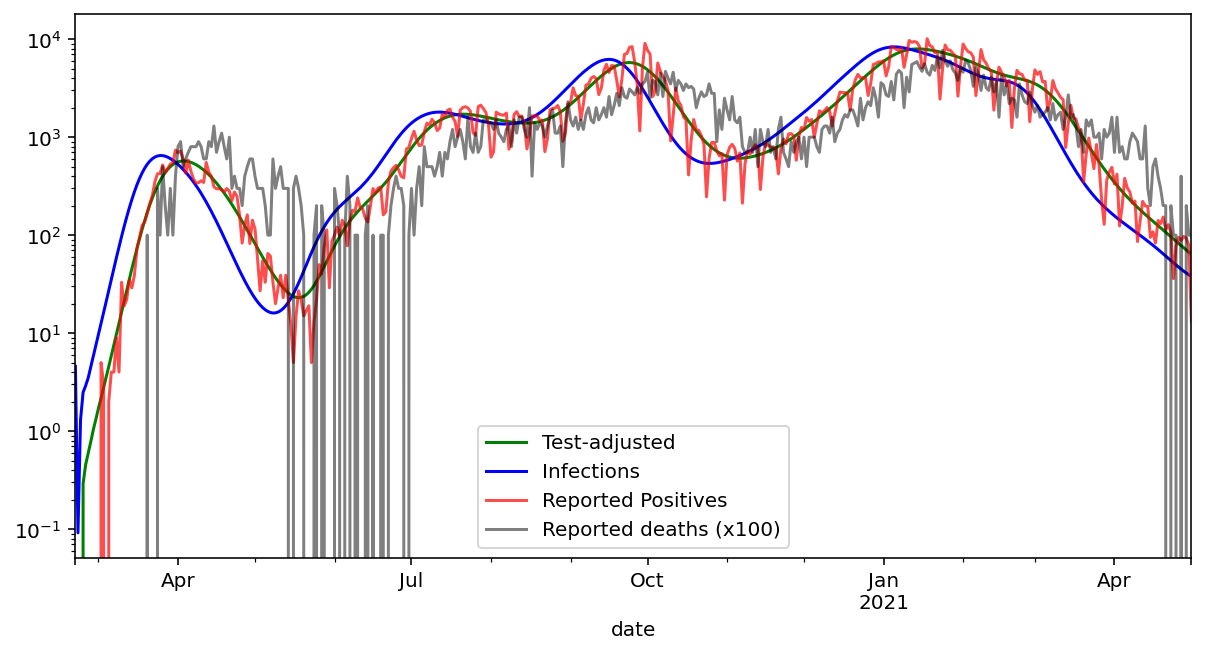

In [11]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmunn.observed.deaths * 100
d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
plt.yscale("log")
fig.set_facecolor('w')
ax.legend();

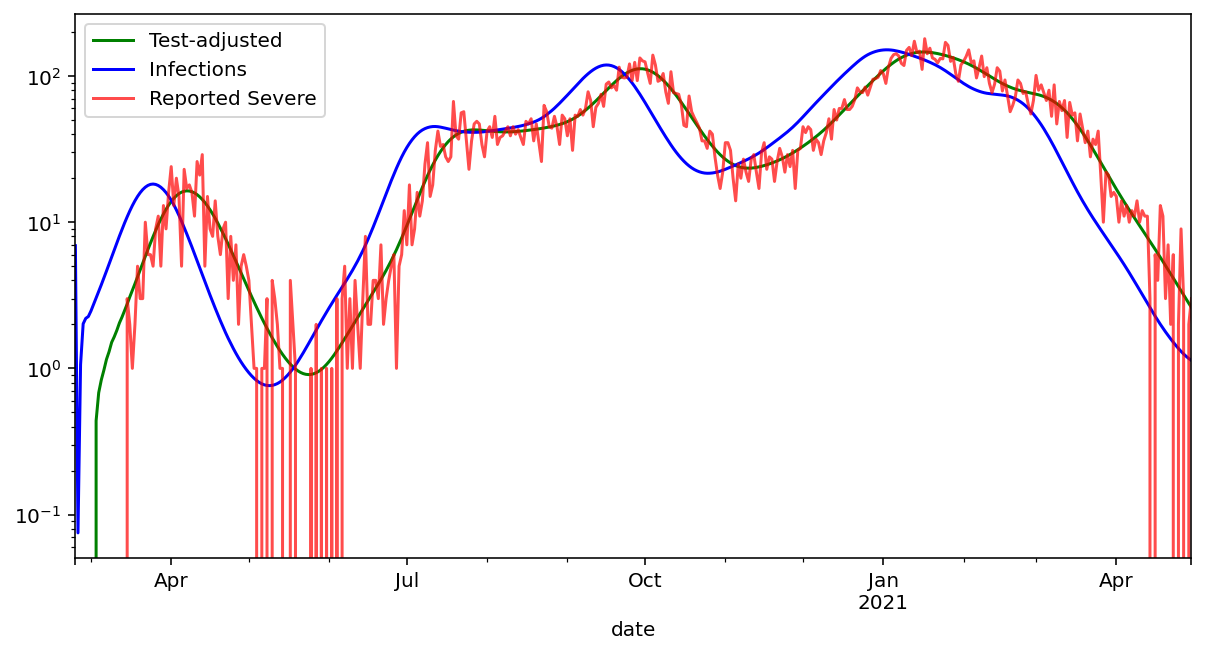

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
resultsev.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsev.infections.plot(c="b", label="Infections")
gmsev.observed.positive.plot(c='r', alpha=.7, label="Reported Severe")
fig.set_facecolor('w')
plt.yscale("log")
ax.legend();

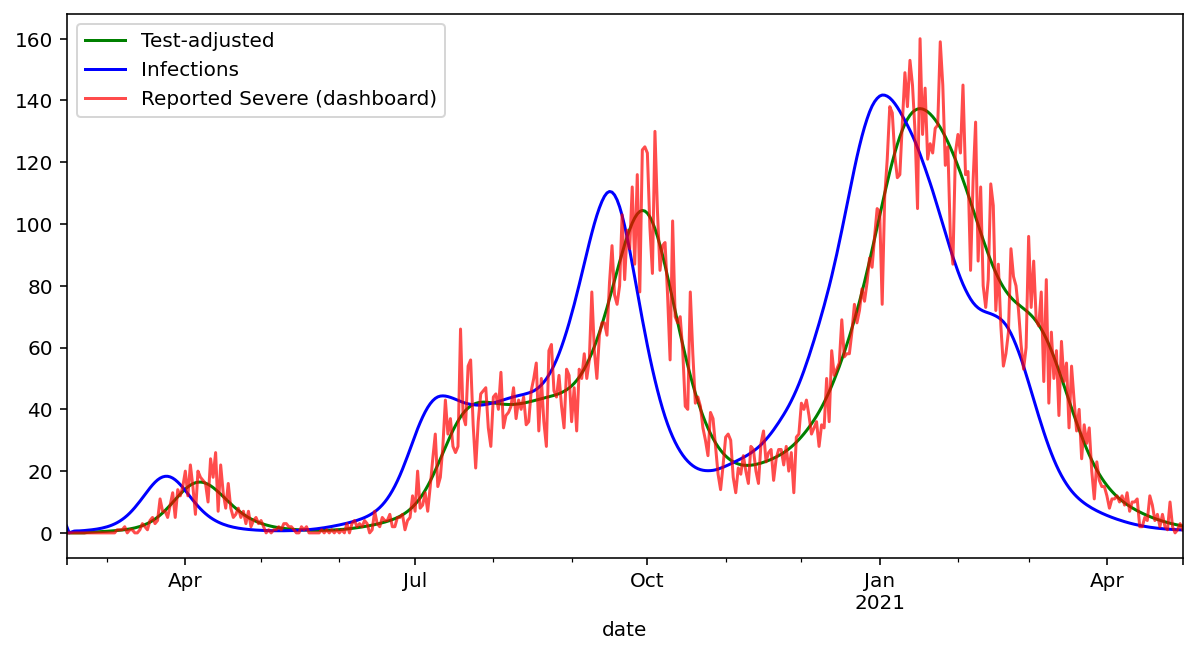

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
resultsevdash.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultsev.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultsevdash.infections.plot(c="b", label="Infections")
gmsevdash.observed.positive.plot(c='r', alpha=.7, label="Reported Severe (dashboard)")
fig.set_facecolor('w')
ax.legend();

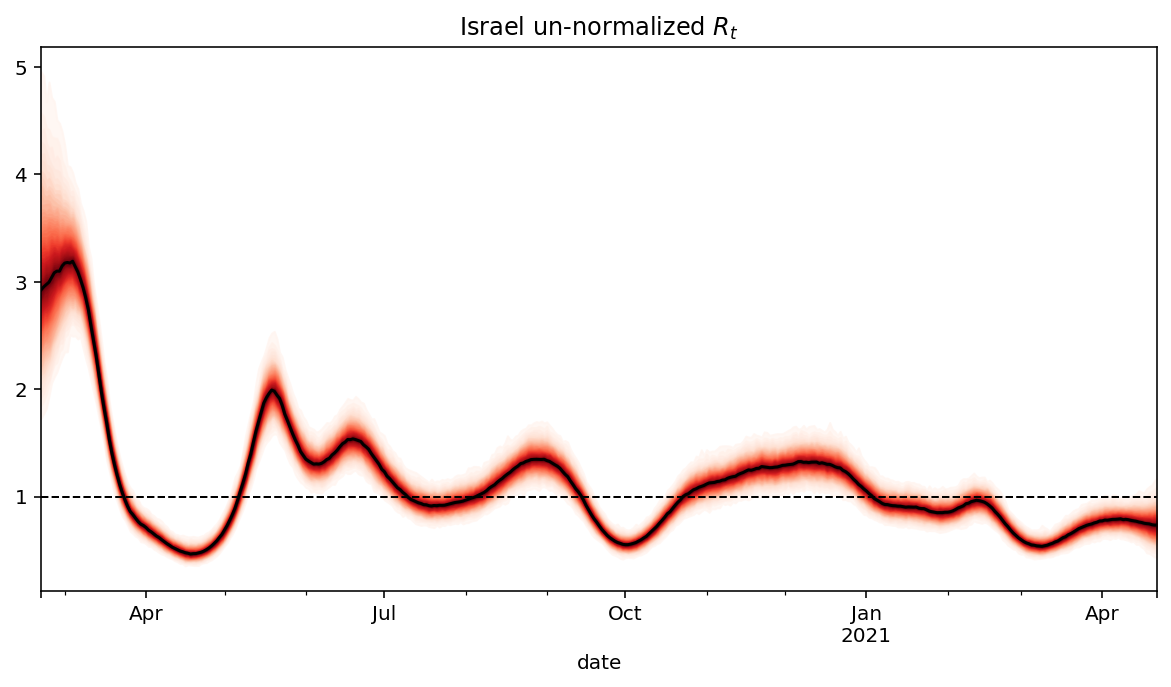

In [14]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultunn["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
fig.savefig("Israel_unnorm_Rt_est.svg")

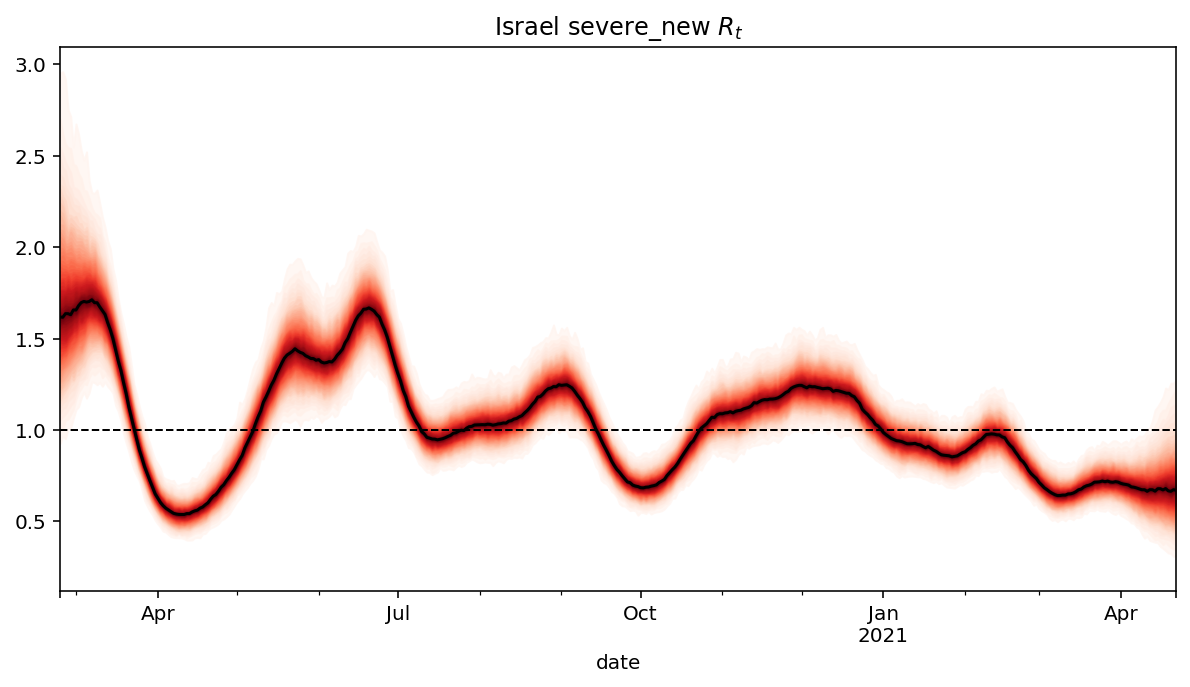

In [15]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new $R_t$")
samples = gmsev.trace['r_t']
x=resultsev.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsev["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

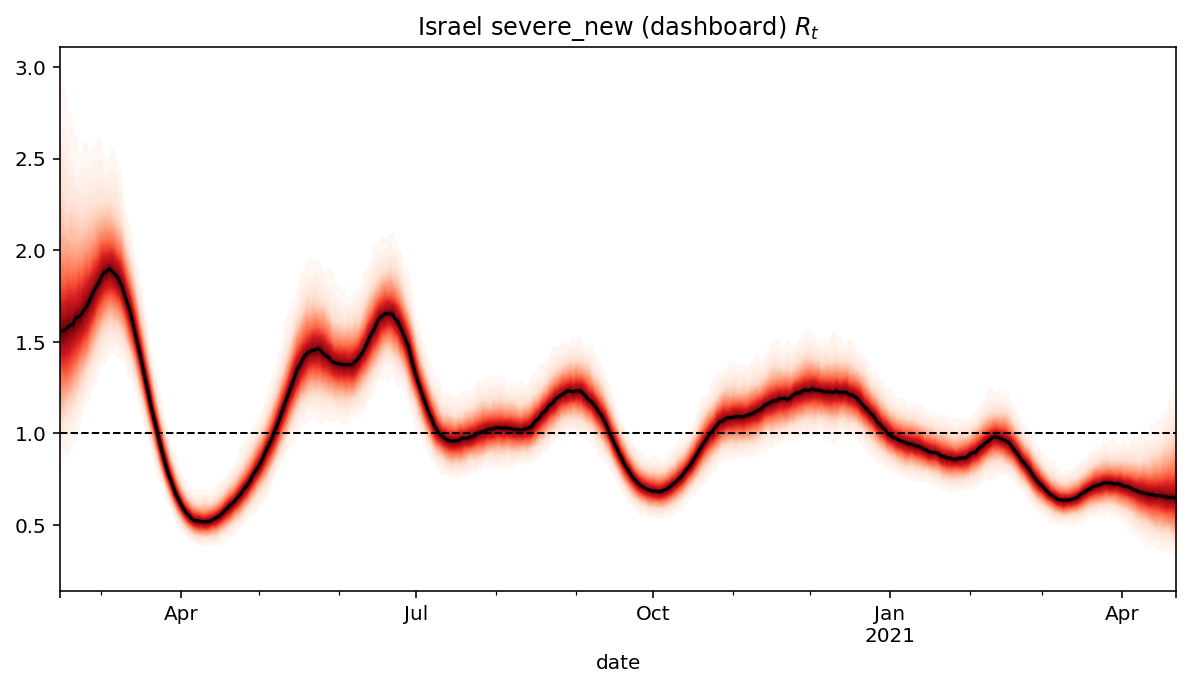

In [16]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} severe_new (dashboard) $R_t$")
samples = gmsevdash.trace['r_t']
x=resultsevdash.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

resultsevdash["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
fig.set_facecolor('w')

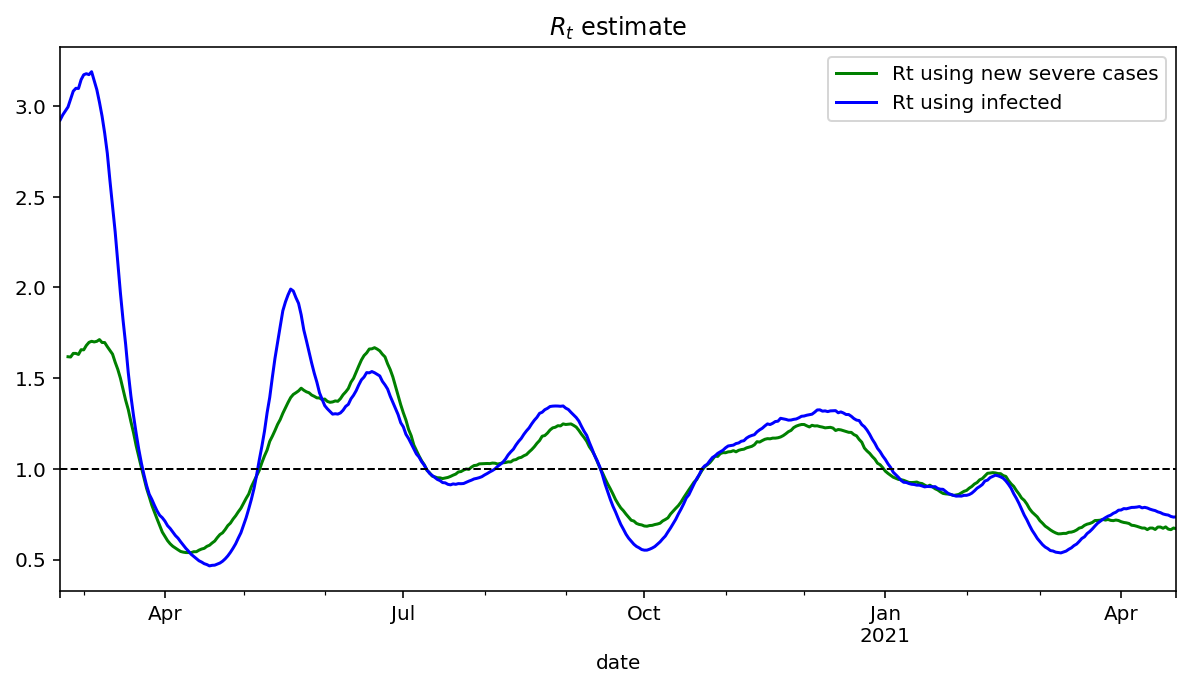

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f"$R_t$ estimate")
resultsev["median"].plot(c="g", ls='-', label="Rt using new severe cases")
#resultsevdash["median"].plot(c="r", ls='-', label="Rt using new severe cases from dashboard")
resultunn["median"].plot(c="b", ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
ax.legend()

In [18]:
resultunn.to_csv("results_unnormalized_out.csv")

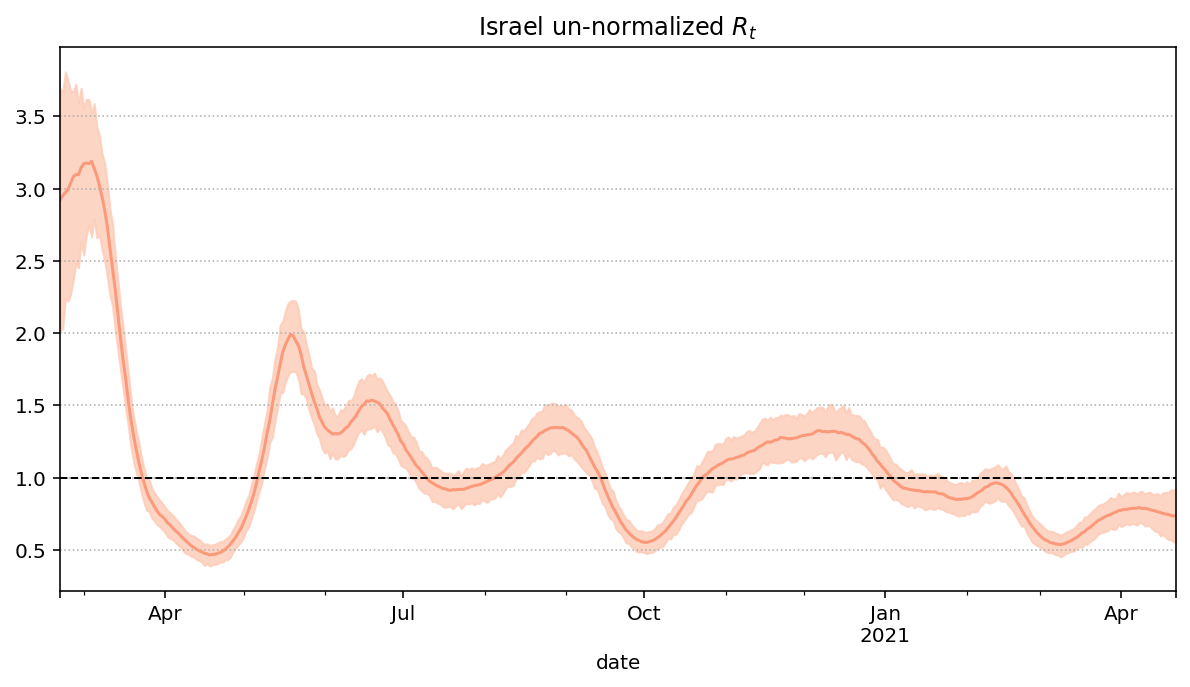

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} un-normalized $R_t$")
samples = gmunn.trace['r_t']
x=resultunn.index
cmap = plt.get_cmap("Reds")
ax.fill_between(x, resultunn["upper_80"], resultunn["lower_80"], color=cmap(50), alpha=.8)
resultunn["median"].plot(c=cmap(90), ls='-', label="Rt using infected")
ax.axhline(1.0, c="k", lw=1, linestyle="--")
ax.set_xlim(right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70), right=pd.Timestamp.today()-pd.Timedelta(days=10))
#ax.set_ylim(top = 2)
fig.set_facecolor('w')
plt.grid(which='major', axis='y', ls=':')
fig.savefig("Israel_unnorm_Rt_est.svg")

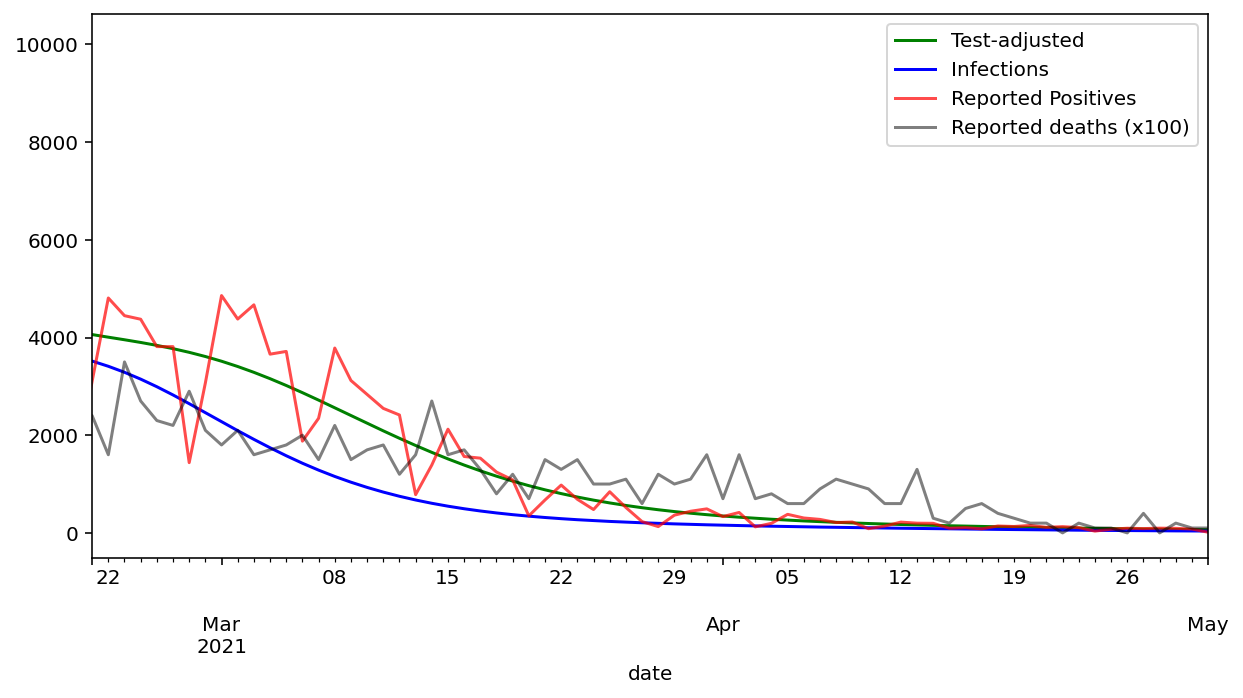

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
resultunn.test_adjusted_positive.plot(c="g", label="Test-adjusted")
#resultunn.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
resultunn.infections.plot(c="b", label="Infections")
gmunn.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
d = gmunn.observed.deaths * 100
d.plot(c='k', alpha=0.5, label="Reported deaths (x100)")
#plt.yscale("log")
ax.set_xlim(left = pd.Timestamp.today()-pd.Timedelta(days=70))
fig.set_facecolor('w')
ax.legend();